# Probability distribution of $2$-Selmer ranks

Heath-Brown proved results predicting probability distribution of $2$-Selmer ranks across residue classes modulo $8$. 
The notebook contains scripts verifying the result and its corollaries. 


In [1]:
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

pq_file = "three_mil_2selmer.parquet"
hb_columns = ['n','2selmer_rank', 'mod8']

table = pq.read_table(pq_file, columns=hb_columns)

# Convert the PyArrow Table to a Pandas DataFrame
df = table.to_pandas()
df['sofd'] = df['2selmer_rank'] - 2
df['size'] = 2 ** (df['sofd'])
odd_df =  df[df['mod8'].isin([1,3,5,7])].drop(columns=['2selmer_rank'])
odd_df['group'] = odd_df['mod8'].map(lambda x: '1_3' if x in [1, 3] else '5_7')

odd_df

,n,mod8,sofd,size,group
0,1,1,0,1,1_3
2,3,3,0,1,1_3
3,5,5,1,2,5_7
5,7,7,1,2,5_7
7,11,3,0,1,1_3
...,...,...,...,...,...
1823766,2999989,5,1,2,5_7
1823768,2999991,7,1,2,5_7
1823769,2999993,1,2,4,1_3
1823770,2999995,3,2,4,1_3


Computation of Empirical Moments

In [2]:
for group in ['1_3', '5_7']:
    subset = odd_df[odd_df['group'] == group]
    freq = subset['sofd'].value_counts(normalize=True).sort_index()
    print(f"Empirical frequencies for group {group}:\n{freq}\n")


Empirical frequencies for group 1_3:
sofd
0    0.454391
2    0.519608
4    0.025929
6    0.000072
Name: proportion, dtype: float64

Empirical frequencies for group 5_7:
sofd
1    0.856714
3    0.141791
5    0.001495
Name: proportion, dtype: float64




Selmer Rank Frequency Comparison Table for Group 1_3:
 sofd  Empirical  Theoretical
    0   0.454391     0.419422
    2   0.519608     0.559230
    4   0.025929     0.063912
    6   0.000072     0.002582

Selmer Rank Frequency Comparison Table for Group 5_7:
 sofd  Empirical  Theoretical
    1   0.856714     0.838845
    3   0.141791     0.223692
    5   0.001495     0.014203


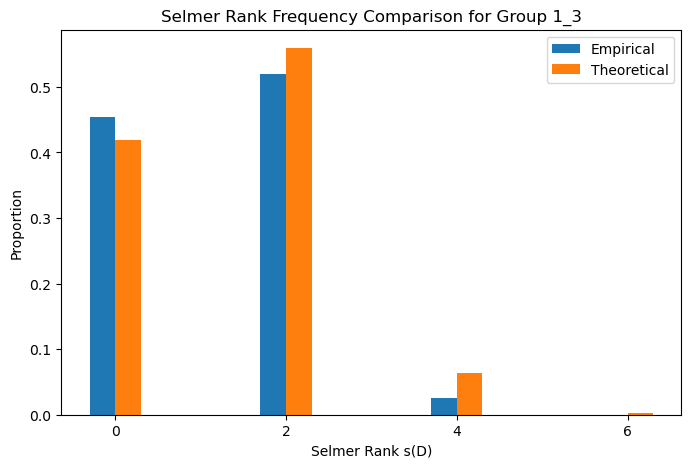

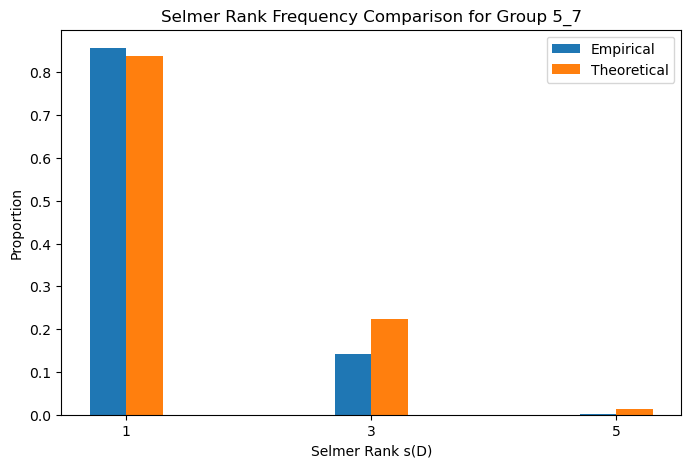

In [3]:
#Theorem 2
from math import prod

def compute_lambda(num_terms=1000):
    return prod([(1 + 2**(-n))**(-1) for n in range(1, num_terms + 1)])

def compute_dr(lambda_val, max_r):
    dr_values = {}
    for r in range(max_r + 1):
        product = prod([1 / (2*j - 1) for j in range(1, r + 1)]) if r > 0 else 1
        dr_values[r] = lambda_val * product * (2**r)
    return dr_values

lambda_val = compute_lambda()
max_sofd = odd_df['sofd'].max()
dr_full = compute_dr(lambda_val, max_sofd)

# Partition dr values by group
theoretical_dr = {
    '1_3': {r: dr_full[r] for r in dr_full if r % 2 == 0},
    '5_7': {r: dr_full[r] for r in dr_full if r % 2 == 1},
}

def plot_frequency_comparison(group_label):
    subset = odd_df[odd_df['group'] == group_label]
    empirical_freq = subset['sofd'].value_counts(normalize=True).sort_index()

    # Prepare dataframe
    emp_df = pd.DataFrame({'sofd': empirical_freq.index, 'Empirical': empirical_freq.values})
    theor_df = pd.DataFrame({'sofd': list(theoretical_dr[group_label].keys()), 
                             'Theoretical': list(theoretical_dr[group_label].values())})

    # Merge and fill missing sofd values
    df = pd.merge(emp_df, theor_df, on='sofd', how='outer').fillna(0).sort_values('sofd')

    # Plot
    label = f"selmer_pmf{group_label}.jpeg"
    plt.figure(figsize=(8, 5))
    plt.bar(df['sofd'] - 0.15, df['Empirical'], width=0.3, label="Empirical")
    plt.bar(df['sofd'] + 0.15, df['Theoretical'], width=0.3, label="Theoretical")
    plt.xticks(df['sofd'])
    plt.legend()
    plt.title(f"Selmer Rank Frequency Comparison for Group {group_label}")
    plt.xlabel("Selmer Rank s(D)")
    plt.ylabel("Proportion")
    plt.savefig(label)
    plt.show()

def print_frequency_comparison_table(group_label):
    subset = odd_df[odd_df['group'] == group_label]
    empirical_freq = subset['sofd'].value_counts(normalize=True).sort_index()

    # Prepare dataframe
    emp_df = pd.DataFrame({'sofd': empirical_freq.index, 'Empirical': empirical_freq.values})
    theor_df = pd.DataFrame({'sofd': list(theoretical_dr[group_label].keys()), 
                             'Theoretical': list(theoretical_dr[group_label].values())})

    # Merge both
    df = pd.merge(emp_df, theor_df, on='sofd', how='outer').fillna(0).sort_values('sofd')

    print(f"\nSelmer Rank Frequency Comparison Table for Group {group_label}:")
    print(df.to_string(index=False))

    return df  # Return for plotting use

# Usage
comparison_tables = {}
for group in ['1_3', '5_7']:
    comparison_tables[group] = print_frequency_comparison_table(group)
    

for group in ['1_3', '5_7']:
    plot_frequency_comparison(group)

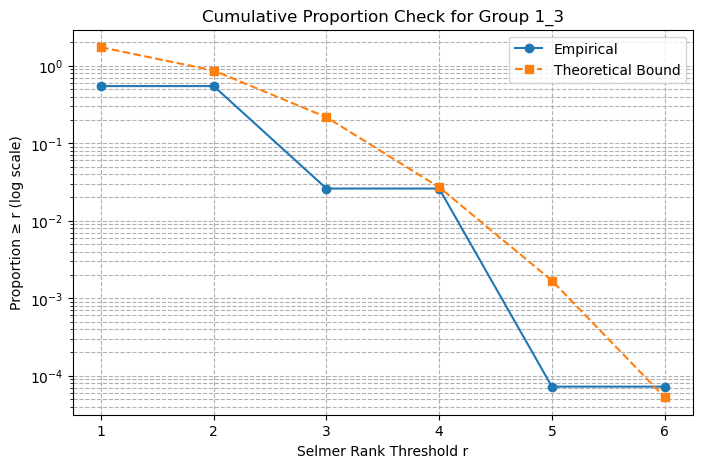

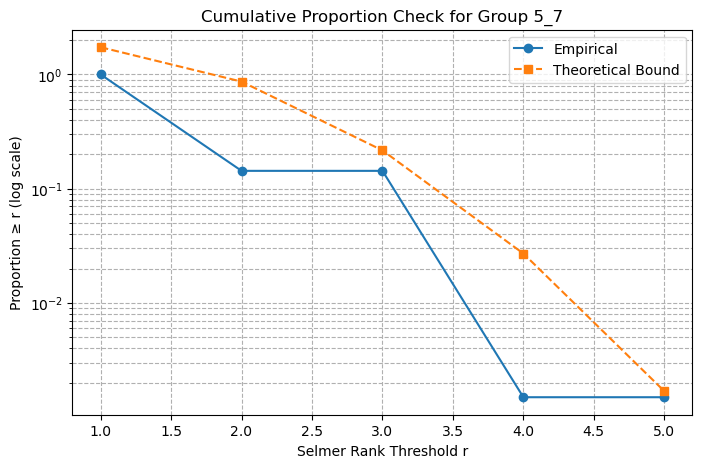

In [4]:
## Corollary 1
import numpy as np

def plot_cumulative_bound(group_label):
    subset = odd_df[odd_df['group'] == group_label]
    max_sofd = subset['sofd'].max()
    
    rs = np.arange(1, max_sofd + 1)
    empirical = [(subset['sofd'] >= r).mean() for r in rs]
    theoretical = [1.7313 * 2 ** (-(r ** 2 - r) / 2) for r in rs]

    plt.figure(figsize=(8, 5))
    plt.plot(rs, empirical, 'o-', label='Empirical')
    plt.plot(rs, theoretical, 's--', label='Theoretical Bound')
    plt.yscale('log')
    plt.xlabel("Selmer Rank Threshold r")
    plt.ylabel("Proportion ≥ r (log scale)")
    plt.title(f"Cumulative Proportion Check for Group {group_label}")
    plt.legend()
    plt.grid(True, which='both', ls='--')
    plt.show()

for group in ['1_3', '5_7']:
    plot_cumulative_bound(group)


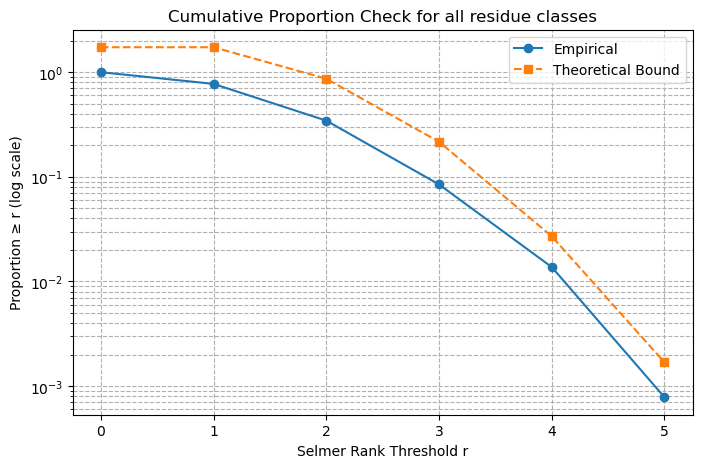

In [5]:
## Corollary 1
import numpy as np

for res in [1,3,5,7]:
    subset = odd_df[odd_df['mod8'] == res]
    max_sofd = subset['sofd'].max()
    rs = np.arange(0, max_sofd + 1)
    empirical = [(odd_df['sofd'] >= r).mean() for r in rs]
    theoretical = [1.7313 * 2 ** (-(r ** 2 - r) / 2) for r in rs]

plt.figure(figsize=(8, 5))
plt.plot(rs, empirical, 'o-', label='Empirical')
plt.plot(rs, theoretical, 's--', label='Theoretical Bound')
plt.yscale('log')
plt.xlabel("Selmer Rank Threshold r")
plt.ylabel("Proportion ≥ r (log scale)")
plt.title(f"Cumulative Proportion Check for all residue classes")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

Validation of Corollary 1: Tail Probabilities
Residue      r          Empirical Prop  Theoretical Bound Total D   
D ≡ 1,3 mod8 0          1.000000        1.731300        607922    
D ≡ 1,3 mod8 2          0.545609        0.865650                  
D ≡ 1,3 mod8 4          0.026002        0.027052                  
D ≡ 1,3 mod8 6          0.000072        0.000053                  

D ≡ 5,7 mod8 1          1.000000        1.731300        607922    
D ≡ 5,7 mod8 3          0.143286        0.216413                  
D ≡ 5,7 mod8 5          0.001495        0.001691                  



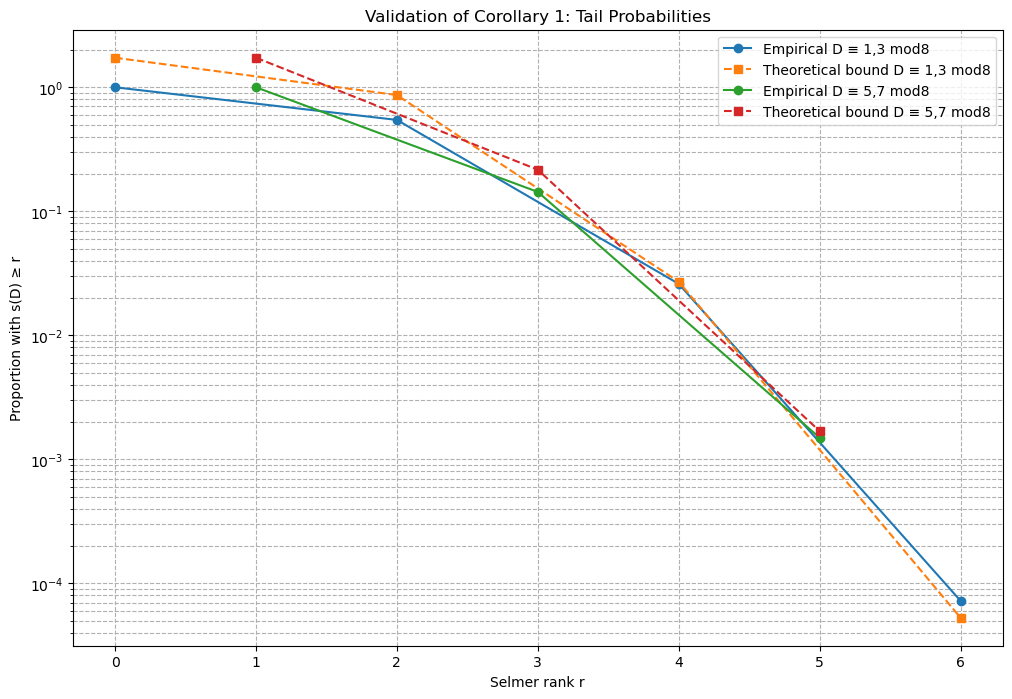

In [8]:
def validate_corollary1(df):
    # Theoretical upper bound from Corollary 1
    C = 1.7313  # The constant from the paper
    
    results = {
        '1,3': {'name': 'D ≡ 1,3 mod8', 'hs': [1, 3], 'start_r': 0, 'step': 2},
        '5,7': {'name': 'D ≡ 5,7 mod8', 'hs': [5, 7], 'start_r': 1, 'step': 2}
    }
    
    for group in results.values():
        # Combine data for both residue classes in group
        subset = df[df['mod8'].isin(group['hs'])]
        total = len(subset)
        
        r_values = []
        empirical_props = []
        theoretical_bounds = []
        
        max_r = max(subset['sofd'])
        
        for r in range(group['start_r'], max_r + 1, group['step']):
            count = len(subset[subset['sofd'] >= r])
            prop = count / total
            bound = C * 2**(-(r**2 - r)/2)
            
            r_values.append(r)
            empirical_props.append(prop)
            theoretical_bounds.append(bound)
        
        group.update({
            'r': r_values,
            'empirical': empirical_props,
            'theoretical': theoretical_bounds,
            'total': total
        })
    
    # Print results in a table
    print("Validation of Corollary 1: Tail Probabilities")
    print("{:<12} {:<10} {:<15} {:<15} {:<10}".format(
        "Residue", "r", "Empirical Prop", "Theoretical Bound", "Total D"))
    
    for group in results.values():
        for i, r in enumerate(group['r']):
            print("{:<12} {:<10} {:<15.6f} {:<15.6f} {:<10}".format(
                group['name'],
                r,
                group['empirical'][i],
                group['theoretical'][i],
                group['total'] if i == 0 else ""  # Only print total once per group
            ))
        print()  # Add empty line between groups
    
    # Plot results in normal scale
    plt.figure(figsize=(12, 8))
    
    for group in results.values():
        plt.plot(group['r'], group['empirical'], 'o-', 
                label=f'Empirical {group["name"]}')
        plt.plot(group['r'], group['theoretical'], 's--', 
                label=f'Theoretical bound {group["name"]}')
    plt.yscale('log')
    plt.xlabel('Selmer rank r')
    plt.ylabel('Proportion with s(D) ≥ r')
    plt.title('Validation of Corollary 1: Tail Probabilities')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    # Add text annotation about the constant C
    '''plt.annotate(f'Note: Theoretical bound is C·2^(-(r²-r)/2) with C ≈ {C}',
                xy=(0.5, 0.95), xycoords='axes fraction',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))'''
    
    plt.savefig("trailp.jpeg")
    plt.show()
    
    return results

corollary1_results = validate_corollary1(odd_df)

**Verification of Corollary 2 of HB's first paper** 

**Part 1** 
The average of s(D) for odd D's that are 1 or 3 mod 8 is = 1.2039.
The average of s(D) for odd D's that are 5 or 7 mod 8 is = 1.3250.


For any odd integer D the average s(D) is at most 4/3. Conequently, s(D) = 0 for at least 1/3 of D that are 1 or 3 (8) and s(D) = 1 for 5/6 of D that are 5 or 7 (8). See also Theorem 2 of the part 2 paper. 

In [5]:
filter_df = df[df['mod8'].isin([1,3])]
avg1 = (filter_df['2selmer_rank']-2).mean()
prp1 = (filter_df['2selmer_rank'] == 2).mean()
print("Average s(D) when n is 1 or 3 (mod 8) =", avg1, "Proportion of numbers with s(D) = 0 is", prp1)

filter_df = df[df['mod8'].isin([5,7])]
avg2 = (filter_df['2selmer_rank']-2).mean()
prp2 = (filter_df['2selmer_rank'] == 3).mean()
print("Average s(D) when n is 5 or 7 (mod 8) =", avg2, "Proportion of numbers with s(D) = 1 is", prp2)

Average s(D) when n is 1 or 3 (mod 8) = 1.1433670766973394 Proportion of numbers with s(D) = 0 is 0.45439053036409277
Average s(D) when n is 5 or 7 (mod 8) = 1.2895634637338342 Proportion of numbers with s(D) = 1 is 0.856713525748369


In [6]:
#Corollary 2
theoretical_mean = {'1_3': 1.2039, '5_7': 1.3250}

means = odd_df.groupby('group')['sofd'].mean().reset_index()
means['Theoretical'] = means['group'].map(theoretical_mean)

print(means)

  group      sofd  Theoretical
0   1_3  1.143367       1.2039
1   5_7  1.289563       1.3250


In [7]:
def validate_corollary2(df):
    # Theoretical constants from Corollary 2
    c_prime = 1.2039  # For h=1,3
    c_double_prime = 1.3250  # For h=5,7
    
    results = {}
    
    for h in [1, 3, 5, 7]:
        subset = df[df['mod8'] == h]
        avg_sofd = subset['sofd'].mean()
        
        theoretical_avg = c_prime if h in [1, 3] else c_double_prime
        
        results[h] = {
            'empirical_avg': avg_sofd,
            'theoretical_avg': theoretical_avg,
            'count': len(subset)
        }
    
    # Print results
    print("Validation of Corollary 2: Average Selmer Ranks")
    print("{:<10} {:<15} {:<15} {:<10}".format(
        "D mod8", "Empirical Avg", "Theoretical Avg", "Count"))
    
    for h in sorted(results.keys()):
        print("{:<10} {:<15.4f} {:<15.4f} {:<10}".format(
            h, 
            results[h]['empirical_avg'], 
            results[h]['theoretical_avg'],
            results[h]['count']))
    
    return results

corollary2_results = validate_corollary2(odd_df)

Validation of Corollary 2: Average Selmer Ranks
D mod8     Empirical Avg   Theoretical Avg Count     
1          1.4511          1.2039          303961    
3          0.8356          1.2039          303961    
5          1.2961          1.3250          303959    
7          1.2830          1.3250          303963    


         X  Max_s(D)  Median_s(D)  log_ratio  Ratio_Max_to_Sqrt_log_X
0    10000         4          1.0   4.148191                 0.964276
1    50000         5          1.0   4.543499                 1.100473
2   100000         5          1.0   4.711711                 1.061186
3   200000         5          1.0   4.878656                 1.024872
4   500000         6          1.0   5.097414                 1.177067
5  1000000         6          1.0   5.261464                 1.140367
6  3000000         6          1.0   5.519030                 1.087148


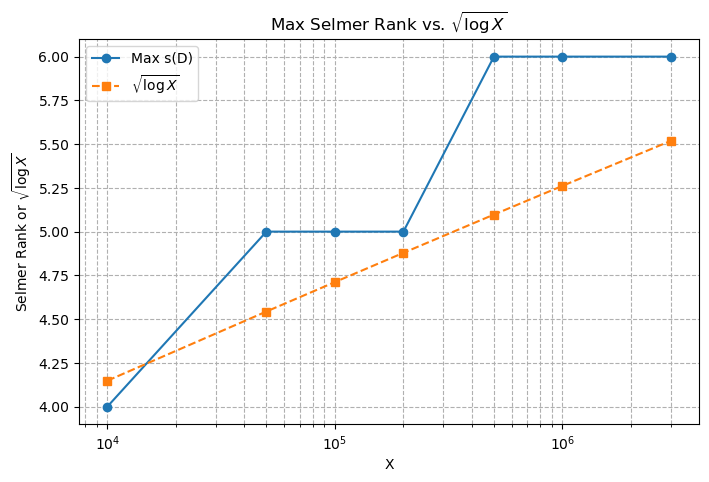

In [10]:
## Stuff on Page 4 of HB2
#s(D) << root(log D)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def selmer_rank_upper_bound_experiment(odd_df, X_cutoffs=None):
    if X_cutoffs is None:
        X_cutoffs = [10_000, 50_000, 100_000, 200_000, 500_000, 10_00_000, 30_00_000]

    results = []
    for X in X_cutoffs:
        subset = odd_df[odd_df['n'] <= X]
        if subset.empty:
            continue
        max_sofd = subset['sofd'].max()
        median_sofd = subset['sofd'].median()
        sqrt_log_X = np.sqrt(np.log(X))
        log_ratio = (np.log(X))/(np.log(np.log(X)))

        results.append({
            'X': X,
            'Max_s(D)': max_sofd,
            'Median_s(D)': median_sofd,
            #'Sqrt_log_X': sqrt_log_X,
            'log_ratio': log_ratio,
            'Ratio_Max_to_Sqrt_log_X': max_sofd / log_ratio
        })

    return pd.DataFrame(results)

def plot_selmer_upper_bound(results_df):
    plt.figure(figsize=(8, 5))
    plt.plot(results_df['X'], results_df['Max_s(D)'], marker='o', label='Max s(D)')
    plt.plot(results_df['X'], results_df['log_ratio'], marker='s', linestyle='--', label=r'$\sqrt{\log X}$')
    plt.xscale('log')
    plt.xlabel('X')
    plt.ylabel('Selmer Rank or $\sqrt{\log X}$')
    plt.title('Max Selmer Rank vs. $\sqrt{\log X}$')
    plt.legend()
    plt.grid(True, which='both', linestyle='--')
    plt.show()

results_df = selmer_rank_upper_bound_experiment(odd_df)
print(results_df)
plot_selmer_upper_bound(results_df)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Log factor function as per Theorem 1 remark
def log_factor_theorem1(X, k):
    power = 4 ** k
    loglogX = np.log(np.log(X))
    logX = np.log(X)
    return (loglogX ** power) / (logX ** (1 / power))

# Main experiment function
def error_term_experiment(odd_df, h_values=[1, 3, 5, 7], k_values=[1, 2], X_cutoffs=None):
    if X_cutoffs is None:
        X_cutoffs = [10_000, 50_000, 100_000, 200_000, 500_000]

    result_rows = []
    for h in h_values:
        for k in k_values:
            c_k = np.prod([1 + 2 ** j for j in range(1, k + 1)])
            for X in X_cutoffs:
                subset = odd_df[(odd_df['mod8'] == h) & (odd_df['n'] <= X)]
                count = len(subset)
                if count == 0:
                    continue
                empirical_sum = (2 ** (k * subset['sofd'])).sum()
                theoretical_sum = c_k * count
                delta = abs(empirical_sum - theoretical_sum)
                log_factor = log_factor_theorem1(X, k)

                result_rows.append({
                    'h': h,
                    'k': k,
                    'X': X,
                    'Delta': delta,
                    'Delta_per_X': delta / X,
                    'Log_Factor': log_factor,
                    'Normalized_Error': (delta / X) / log_factor
                })
    return pd.DataFrame(result_rows)

# Plotting function: one plot per h, overlaying both k values, saving figures with color palette
def plot_error_vs_logfactor(result_df, save_dir="plots"):
    os.makedirs(save_dir, exist_ok=True)

    h_values = result_df['h'].unique()
    k_values = result_df['k'].unique()
    color_palette = plt.get_cmap("tab10")

    for h in h_values:
        plt.figure(figsize=(8, 5))
        for idx, k in enumerate(k_values):
            df_sub = result_df[(result_df['h'] == h) & (result_df['k'] == k)]
            if df_sub.empty:
                continue
            plt.plot(df_sub['X'], df_sub['Normalized_Error'], marker='o', linestyle='-', 
                     color=color_palette(idx), label=f'k = {k}')
        plt.xscale('log')
        plt.xlabel("X (log scale)")
        plt.ylabel("Delta(X)/[X * log factor]")
        plt.title(f"Normalized Error for h = {h}, k overlay")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/normalized_error_h{h}.png", dpi=300)
        plt.close()

# Experiment for Selmer rank upper bound growth
def selmer_rank_upper_bound_experiment(odd_df, X_cutoffs=None):
    if X_cutoffs is None:
        X_cutoffs = [10_000, 50_000, 100_000, 200_000, 500_000]

    results = []
    for X in X_cutoffs:
        subset = odd_df[odd_df['n'] <= X]
        if subset.empty:
            continue
        max_sofd = subset['sofd'].max()
        median_sofd = subset['sofd'].median()
        percentile_95 = subset['sofd'].quantile(0.95)
        sqrt_log_X = np.sqrt(np.log(X))

        results.append({
            'X': X,
            'Max_s(D)': max_sofd,
            'Median_s(D)': median_sofd,
            'Percentile_95_s(D)': percentile_95,
            'Sqrt_log_X': sqrt_log_X,
            'Ratio_Max_to_Sqrt_log_X': max_sofd / sqrt_log_X
        })

    return pd.DataFrame(results)

# Plotting function for Selmer rank upper bound growth
def plot_selmer_upper_bound(results_df, save_path="selmer_rank_growth.png"):
    plt.figure(figsize=(8, 5))
    plt.plot(results_df['X'], results_df['Max_s(D)'], marker='o', label='Max s(D)')
    plt.plot(results_df['X'], results_df['Median_s(D)'], marker='s', linestyle='--', label='Median s(D)')
    plt.plot(results_df['X'], results_df['Percentile_95_s(D)'], marker='^', linestyle='-.', label='95th Percentile s(D)')
    plt.plot(results_df['X'], results_df['Sqrt_log_X'], marker='x', linestyle=':', label=r'$\sqrt{\log X}$')
    plt.xscale('log')
    plt.xlabel('X (log scale)')
    plt.ylabel('Selmer Rank Statistics')
    plt.title('Selmer Rank Growth Compared to $\sqrt{\log X}$')
    plt.legend()
    plt.grid(True, which='both', linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

result_df_error = error_term_experiment(odd_df)
plot_error_vs_logfactor(result_df_error)

result_df_rank = selmer_rank_upper_bound_experiment(odd_df)
plot_selmer_upper_bound(result_df_rank)

result_df_error.to_csv("error_term_experiment_results.csv", index=False)
result_df_rank.to_csv("selmer_rank_growth_results.csv", index=False)